In [28]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'user_id': [12315133,42645131], 'sum_usd': [120, 280], 'date': ['2025-01-01', '2025-01-05']})
df

,user_id,sum_usd,date
0,12315133,120,2025-01-01
1,42645131,280,2025-01-05


-----

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from dateutil.relativedelta import relativedelta


def generate_synthetic_data(start_date: str, end_date: str, n_users: int) -> pd.DataFrame:
    """Генерация синтетических данных с постепенным добавлением пользователей."""
    np.random.seed(42)
    
    dates = pd.date_range(start_date, end_date)
    data = []
    
    for user_id in range(n_users):
        # Случайная дата регистрации пользователя
        registration_date = np.random.choice(dates)
    
        # Генерируем данные только для дат после регистрации
        for date in dates[dates >= registration_date]:
            num_withdrawals = np.random.choice([0, 1, 2], p=[0.7, 0.2, 0.1])
            for _ in range(num_withdrawals):
                amount = round(np.random.uniform(10, 1000), 2)
                feature_1 = np.random.randint(100, 200)
                feature_2 = np.random.choice([0, 1, 2], p=[0.2, 0.7, 0.1])
                # Возраст увеличивается с каждой датой
                user_lifetime = (date - registration_date).days

                # Влияние признаков на target
                base_probability = 0.1
                probability_boost = (amount / 1000) * 0.3 + \
                                    (feature_1 / 200) * 0.02 + \
                                    (feature_2 / 2) * 0.01
                if user_lifetime < 100:
                    probability_boost += 0.2
                elif user_lifetime < 200:
                    probability_boost += 0.01
                else:
                    probability_boost += 0.005
                probability = base_probability + probability_boost
    
                target = np.random.choice([0, 1], p=[1 - probability, probability])
    
                data.append({
                    'user_id': user_id,
                    'date': date,
                    'amount': amount,
                    'feature_1': feature_1,
                    'feature_2': feature_2,
                    'user_lifetime': user_lifetime,
                    'target': target
                })
    return pd.DataFrame(data)

start_date = '2023-01-01'
end_date = '2024-04-30'
n_users = 200
df = generate_synthetic_data(start_date, end_date, n_users)
start_date = pd.to_datetime(start_date)
df['month_number'] = df['date'].apply(lambda date: relativedelta(date, start_date).months + 12 * relativedelta(date, start_date).years + 1)

print('Shape:', df.shape)
val_counts = df['target'].value_counts()
zero_class_weight = round(100 - val_counts[1]*100/(val_counts[0]+val_counts[1]),2)
first_class_weight = round(val_counts[1]*100/(val_counts[0]+val_counts[1]),2)
print(f'\nClass weights\n1: {first_class_weight}\n0: {zero_class_weight}')
print(f'Month numbers: {sorted(df['month_number'].unique(), reverse=True)}')
df.head(5)

Shape: (20508, 8)

Class weights
1: 34.24
0: 65.76
Month numbers: [16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


,user_id,date,amount,feature_1,feature_2,user_lifetime,target,month_number
0,0,2023-04-13,191.60,171,1,0,0,4
1,0,2023-04-16,605.10,123,1,3,0,4
2,0,2023-04-17,939.17,101,0,4,0,4
3,0,2023-04-27,207.68,154,2,14,0,4
4,0,2023-04-28,683.50,172,0,15,1,4


In [11]:
def categorize_user_lifetime(user_lifetime: int) -> str:
    """Категоризация user_lifetime"""
    if user_lifetime < 100:
        return 'young'
    elif user_lifetime < 200:
        return 'average'
    else:
        return 'elderly'

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Работа с признаками для замедления устаревания"""
    # user_lifetime
    df['user_lifetime_category'] = df['user_lifetime'].apply(categorize_user_lifetime)
    df.drop(['user_lifetime'], axis=1, inplace=True)
    return df

df = feature_engineering(df)

print(df['user_lifetime_category'].value_counts())
df.head()

user_lifetime_category
elderly    7664
young      7158
average    5686
Name: count, dtype: int64


,user_id,date,amount,feature_1,feature_2,target,month_number,user_lifetime_category
0,0,2023-04-13,191.60,171,1,0,4,young
1,0,2023-04-16,605.10,123,1,0,4,young
2,0,2023-04-17,939.17,101,0,0,4,young
3,0,2023-04-27,207.68,154,2,0,4,young
4,0,2023-04-28,683.50,172,0,1,4,young


In [12]:
def split_features_target(data: pd.DataFrame) -> tuple:
    """Разделяет входной DataFrame на матрицу признаков (X) и вектор целевой переменной (y)"""
    X = data.drop(['target', 'user_id','date','month_number'], axis=1)
    y = data['target']
    return X,y

def train_and_evaluate(data: pd.DataFrame, cat_features: list, show_eval_res=False) -> tuple:
    """Обучает модель и оценивает ее качество."""

    df_train_val = data[data['month_number'] < data['month_number'].max()]
    df_test = data[data['month_number'] == data['month_number'].max()]

    print(f'\ntrain_val month numbers: {sorted(df_train_val['month_number'].unique(),reverse=True)}')
    print(f'test month numbers: {sorted(df_test['month_number'].unique(),reverse=True)}')

    X_train_val, y_train_val = split_features_target(df_train_val)
    X_test, y_test = split_features_target(df_test)

    val_counts = y_train_val.value_counts()
    zero_class_weight = round(1-val_counts[1]/(val_counts[0]+val_counts[1]),2)
    first_class_weight = round(val_counts[1]/(val_counts[0]+val_counts[1]),2)
    class_weights = [zero_class_weight, first_class_weight]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, 
                                                      random_state=42, stratify=y_train_val)

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    validate_pool = Pool(X_val, y_val, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        random_state=42,
        verbose=0,
        class_weights=class_weights,
        eval_metric='AUC',
        early_stopping_rounds=50
    )

    model.fit(train_pool, eval_set=validate_pool)

    y_pred_proba = model.predict_proba(X_train_val)[:, 1]
    auc_val = roc_auc_score(y_train_val, y_pred_proba)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba)

    if show_eval_res is True:
        print(f'Validate AUC: {round(auc_val,3)}')
        print(f'Test AUC: {round(auc_test,3)}')
    
    return auc_val, auc_test, model

In [13]:
def find_optimal_data_window(df, date_column, window_sizes=None, cat_features=None):
    """
    Находит оптимальный временной период для обучения модели.
    """
    if window_sizes is None:
        window_sizes = range(1,23)

    results_val = {}
    results_test = {}
    list_windows = sorted(df['month_number'].unique())[::-1]
    for i in range(2, len(list_windows) + 1):
        window = list_windows[:i]
        truncated_df = df[df['month_number'].isin(window)]
        # print(truncated_df['month_number'].unique(), len(truncated_df))
        window = len(window)-1

        if len(truncated_df) == 0:
            print(f"Предупреждение: Нет данных для окна {window} месяцев. Пропускаем.")
            results_val[f'{window}'] = -np.inf
            results_test[f'{window}'] = -np.inf
            continue

        try:
            auc_val, auc_test, trained_model = train_and_evaluate(truncated_df, cat_features=cat_features, show_eval_res=False)
            results_val[f'{window}'] = auc_val
            results_test[f'{window}'] = auc_test
            print(f"Test AUC для окна {window} месяцев: {auc_test}")
        except Exception as e:
            print(f"Ошибка при обучении модели для окна {window} месяцев: {e}")
            results_val[f'{window}'] = -np.inf
            results_test[f'{window}'] = -np.inf

    best_window = max(results_test, key=results_test.get)
    best_auc = results_test[best_window]

    print(f"\nЛучший размер окна: {best_window} месяцев с AUC: {best_auc}")

    return int(best_window), best_auc, results_test, results_val

# Определяем категориальные признаки
categorical_features = ['feature_2','user_lifetime_category']
# Запускаем поиск оптимального окна
best_window, best_auc,  results_test, results_val = find_optimal_data_window(df, 'date', cat_features=categorical_features)


train_val month numbers: [15]
test month numbers: [16]
Test AUC для окна 1 месяцев: 0.6377971915713347

train_val month numbers: [15, 14]
test month numbers: [16]
Test AUC для окна 2 месяцев: 0.6414627655080349

train_val month numbers: [15, 14, 13]
test month numbers: [16]
Test AUC для окна 3 месяцев: 0.6438457898916845

train_val month numbers: [15, 14, 13, 12]
test month numbers: [16]
Test AUC для окна 4 месяцев: 0.6444067997093563

train_val month numbers: [15, 14, 13, 12, 11]
test month numbers: [16]
Test AUC для окна 5 месяцев: 0.6434845975768431

train_val month numbers: [15, 14, 13, 12, 11, 10]
test month numbers: [16]
Test AUC для окна 6 месяцев: 0.6419768836918501

train_val month numbers: [15, 14, 13, 12, 11, 10, 9]
test month numbers: [16]
Test AUC для окна 7 месяцев: 0.641621183189983

train_val month numbers: [15, 14, 13, 12, 11, 10, 9, 8]
test month numbers: [16]
Test AUC для окна 8 месяцев: 0.6432666148464828

train_val month numbers: [15, 14, 13, 12, 11, 10, 9, 8, 7]


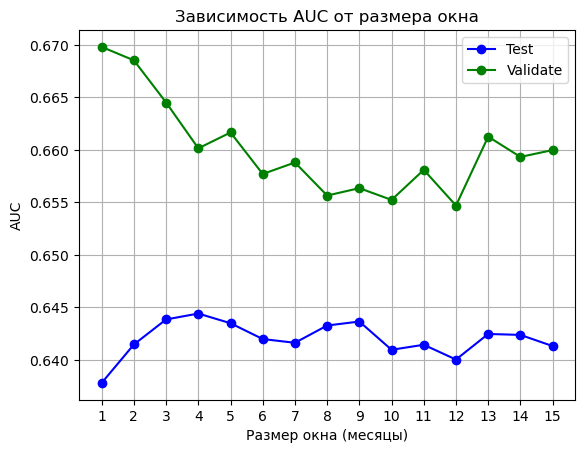

In [14]:
# Визуализация
def create_plot_auc(results: dict, color:str, label:str):
    """Создает линейный график зависимости AUC от размера окна"""
    window_sizes = list(results.keys())
    auc_scores = list(results.values())
    plt.plot(window_sizes, auc_scores, marker='o', color=color, label=label)

create_plot_auc(results_test, 'blue','Test')
create_plot_auc(results_val, 'green', 'Validate')
plt.xlabel("Размер окна (месяцы)")
plt.ylabel("AUC")
plt.title("Зависимость AUC от размера окна")
plt.grid(True)
plt.legend()
plt.show()

In [15]:
results = {}
list_windows = sorted(df['month_number'].unique())[::-1]
for i in range(1, df['month_number'].max()):
    window = list_windows[i:i+best_window+1]
    if len(window) > best_window:
        truncated_df = df[df['month_number'].isin(window)]
    
        # Определяем категориальные признаки
        categorical_features = ['feature_2','user_lifetime_category']
        auc_val, auc_test, trained_model = train_and_evaluate(truncated_df, cat_features=categorical_features)
        results[i] = auc_test
        print(f"Test AUC для окна {best_window} и сдвига {i} (месяцы): {auc_test}")



train_val month numbers: [14, 13, 12, 11]
test month numbers: [15]
Test AUC для окна 4 и сдвига 1 (месяцы): 0.6599089542016556

train_val month numbers: [13, 12, 11, 10]
test month numbers: [14]
Test AUC для окна 4 и сдвига 2 (месяцы): 0.6504045645215801

train_val month numbers: [12, 11, 10, 9]
test month numbers: [13]
Test AUC для окна 4 и сдвига 3 (месяцы): 0.6577949019926359

train_val month numbers: [11, 10, 9, 8]
test month numbers: [12]
Test AUC для окна 4 и сдвига 4 (месяцы): 0.6481294966715759

train_val month numbers: [10, 9, 8, 7]
test month numbers: [11]
Test AUC для окна 4 и сдвига 5 (месяцы): 0.6521873563839853

train_val month numbers: [9, 8, 7, 6]
test month numbers: [10]
Test AUC для окна 4 и сдвига 6 (месяцы): 0.6497580844955477

train_val month numbers: [8, 7, 6, 5]
test month numbers: [9]
Test AUC для окна 4 и сдвига 7 (месяцы): 0.6570639452363334

train_val month numbers: [7, 6, 5, 4]
test month numbers: [8]
Test AUC для окна 4 и сдвига 8 (месяцы): 0.6121815908735

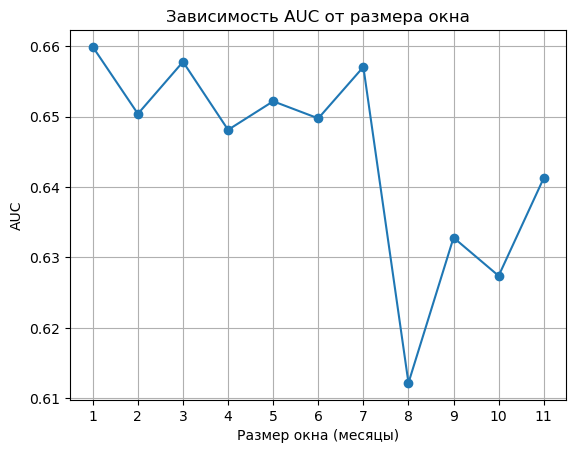

In [16]:
# Визуализация
window_sizes = list(results.keys())
auc_scores = list(results.values())

plt.plot(window_sizes, auc_scores, marker='o')
plt.xlabel("Размер окна (месяцы)")
plt.ylabel("AUC")
plt.title("Зависимость AUC от размера окна")
plt.xticks(window_sizes)
plt.grid(True)
plt.show()

In [17]:
results = {}
list_windows = sorted(df['month_number'].unique())[::-1]
window = list_windows[-best_window:]
list_windows = list_windows[:-best_window][::-1]
count_shift = 0
for i in list_windows:
    window.append(i)
    truncated_df = df[df['month_number'].isin(window)]
    window.pop()
    count_shift += 1

    # Определяем категориальные признаки
    categorical_features = ['feature_2','user_lifetime_category']
    auc_val, auc_test, trained_model = train_and_evaluate(truncated_df, cat_features=categorical_features)
    results[count_shift] = auc_test
    print(f"Test AUC для окна {best_window} и сдвига {count_shift} (месяцы): {auc_test}")


train_val month numbers: [4, 3, 2, 1]
test month numbers: [5]
Test AUC для окна 4 и сдвига 1 (месяцы): 0.6412774688552638

train_val month numbers: [4, 3, 2, 1]
test month numbers: [6]
Test AUC для окна 4 и сдвига 2 (месяцы): 0.6333972267106001

train_val month numbers: [4, 3, 2, 1]
test month numbers: [7]
Test AUC для окна 4 и сдвига 3 (месяцы): 0.6205731495974957

train_val month numbers: [4, 3, 2, 1]
test month numbers: [8]
Test AUC для окна 4 и сдвига 4 (месяцы): 0.597177684013127

train_val month numbers: [4, 3, 2, 1]
test month numbers: [9]
Test AUC для окна 4 и сдвига 5 (месяцы): 0.6200572859223685

train_val month numbers: [4, 3, 2, 1]
test month numbers: [10]
Test AUC для окна 4 и сдвига 6 (месяцы): 0.6161048689138576

train_val month numbers: [4, 3, 2, 1]
test month numbers: [11]
Test AUC для окна 4 и сдвига 7 (месяцы): 0.6064169324970938

train_val month numbers: [4, 3, 2, 1]
test month numbers: [12]
Test AUC для окна 4 и сдвига 8 (месяцы): 0.611823717402049

train_val mont

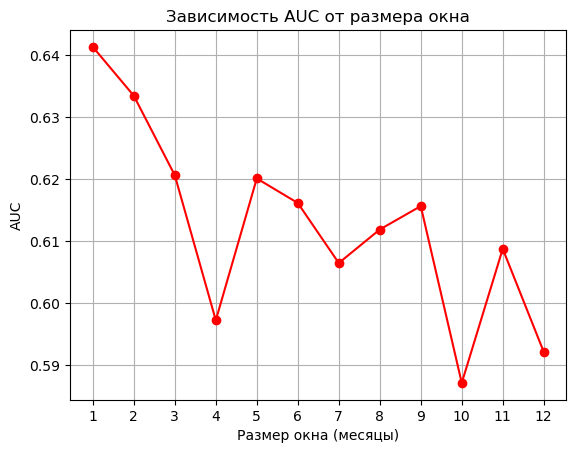

In [18]:
# Визуализация
window_sizes = list(results.keys())
auc_scores = list(results.values())

plt.plot(window_sizes, auc_scores, marker='o', color='red')
plt.xlabel("Размер окна (месяцы)")
plt.ylabel("AUC")
plt.title("Зависимость AUC от размера окна")
plt.xticks(window_sizes)
plt.grid(True)
plt.show()

----

Тест Колмогорова-Смирнова
K-S Statistic: 0.419
P-value: 0.000


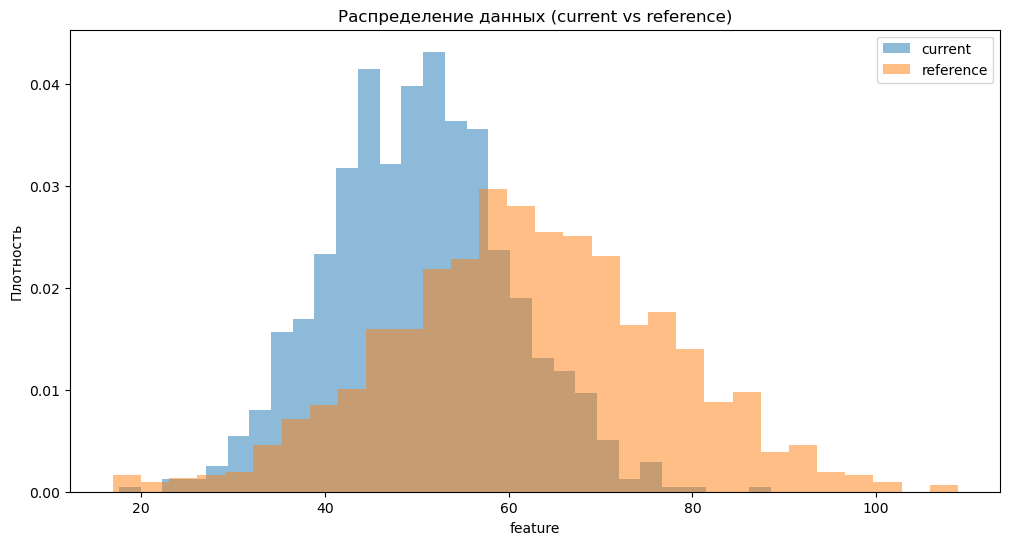

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

np.random.seed(42)
сurrent= pd.DataFrame({
    'feature': np.random.normal(loc=50, scale=10, size=1000),
})
reference = pd.DataFrame({
    'feature': np.random.normal(loc=61, scale=15, size=1000),
})

# 2. Функция для визуализации распределений
def visualize_drift(сurrent, reference, feature_name, num_bins=30):
    """
    Визуализирует распределение признака для обучающего и тестового наборов данных,
    а также выполняет тест Колмогорова-Смирнова для оценки дрифта.
    """

    plt.figure(figsize=(12, 6))

    # Гистограммы
    plt.hist(сurrent[feature_name], bins=num_bins, alpha=0.5, label='сurrent', density=True)
    plt.hist(reference[feature_name], bins=num_bins, alpha=0.5, label='reference', density=True)

    # Название и легенда
    plt.xlabel(feature_name)
    plt.ylabel('Плотность')
    plt.title(f'Распределение данных (сurrent vs reference)')
    plt.legend(loc='upper right')

    # Тест Колмогорова-Смирнова (K-S тест)
    ks_statistic, p_value = stats.ks_2samp(сurrent[feature_name], reference[feature_name])
    print('Тест Колмогорова-Смирнова')
    print(f'K-S Statistic: {ks_statistic:.3f}\nP-value: {p_value:.3f}')

    plt.show()

visualize_drift(сurrent, reference, 'feature')